### Imports

In [1]:
import matplotlib.pyplot as plt
import cv as cv
import numpy as np
import os
from tqdm import tqdm

### Autocrop and renaming

(3000, 4000, 3)


(-0.5, 3631.5, 2319.5, -0.5)

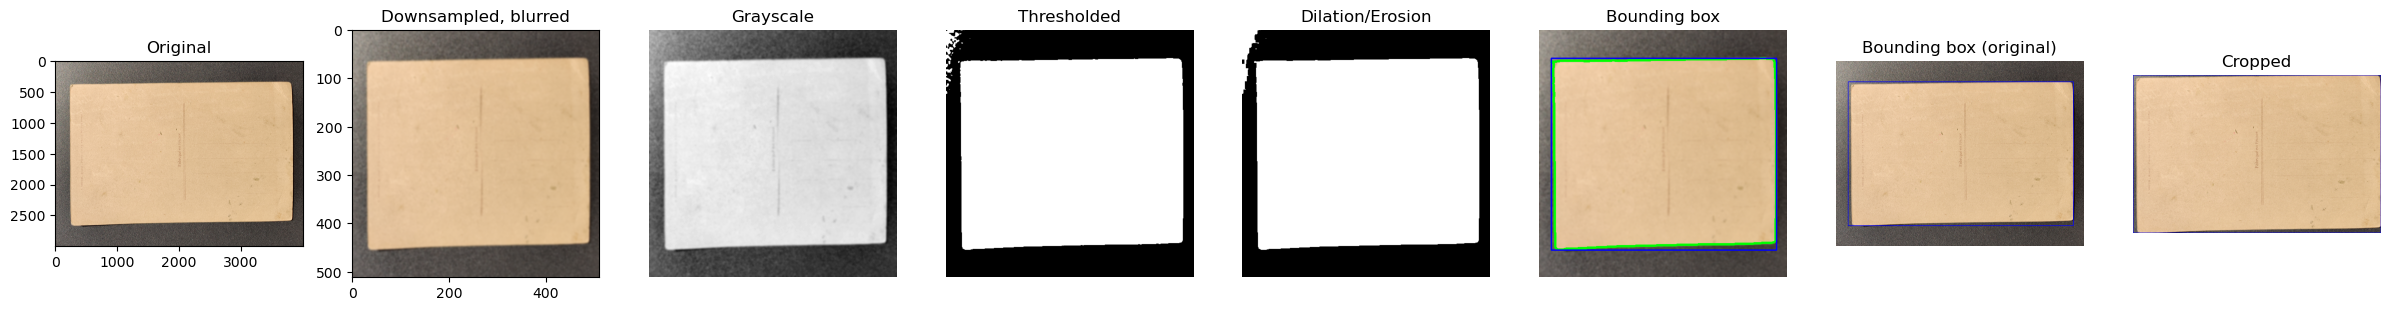

In [33]:
fig, axes = plt.subplots(1, 8, figsize=(30, 5))
    
# Plot random image from raw folder
img_list = os.listdir('raw')
i = np.random.randint(0, len(img_list))
orig_img = cv.imread('raw/' + img_list[i])
print(orig_img.shape)
orig_shape = orig_img.shape

axes[0].imshow(cv.cvtColor(orig_img, cv.COLOR_BGR2RGB))
axes[0].set_title('Original')

# Downsample to (512, 512)
img = cv.resize(orig_img, (512, 512))
# Gaussian blur
img = cv.GaussianBlur(img, (9, 9), 0)

axes[1].imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
axes[1].set_title('Downsampled, blurred')

# Convert to grayscale
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
axes[2].imshow(gray, cmap='gray')
axes[2].set_title('Grayscale')
axes[2].axis('off')

# Thresholding
_, thresh = cv.threshold(gray, 150, 255, cv.THRESH_BINARY)
axes[3].imshow(thresh, cmap='gray')
axes[3].set_title('Thresholded')
axes[3].axis('off')

# Dilation and erosion
kernel = np.ones((5, 5), np.uint8)
dilated = cv.dilate(thresh, kernel, iterations=2)
eroded = cv.erode(dilated, kernel, iterations=2)
axes[4].imshow(eroded, cmap='gray')
axes[4].set_title('Dilation/Erosion')
axes[4].axis('off')

# Find contours
contours, _ = cv.findContours(eroded, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
# Find largest contour
max_area = 0
max_contour = None
for contour in contours:
    area = cv.contourArea(contour)
    if area > max_area:
        max_area = area
        max_contour = contour
# Draw contour
cv.drawContours(img, [max_contour], -1, (0, 255, 0), 3)

# Bounding box rectangle
x, y, w, h = cv.boundingRect(max_contour)
cv.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
axes[5].imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
axes[5].set_title('Bounding box')
axes[5].axis('off')

# Back to original shape
x = int(x * orig_shape[1] / 512)
y = int(y * orig_shape[0] / 512)
w = int(w * orig_shape[1] / 512)
h = int(h * orig_shape[0] / 512)

cv.rectangle(orig_img, (x, y), (x + w, y + h), (255, 0, 0), 10)
axes[6].imshow(cv.cvtColor(orig_img, cv.COLOR_BGR2RGB))
axes[6].set_title('Bounding box (original)')
axes[6].axis('off')

# Crop to bounding box
crop = orig_img[y:y+h, x:x+w]
axes[7].imshow(cv.cvtColor(crop, cv.COLOR_BGR2RGB))
axes[7].set_title('Cropped')
axes[7].axis('off')

In [34]:
def crop_img(img_path):
    orig_img = cv.imread(img_path)
    orig_shape = orig_img.shape
    img = cv.resize(orig_img, (512, 512))
    img = cv.GaussianBlur(img, (9, 9), 0)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    _, thresh = cv.threshold(gray, 150, 255, cv.THRESH_BINARY)
    kernel = np.ones((5, 5), np.uint8)
    dilated = cv.dilate(thresh, kernel, iterations=2)
    eroded = cv.erode(dilated, kernel, iterations=2)
    contours, _ = cv.findContours(eroded, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    max_area = 0
    max_contour = None
    for contour in contours:
        area = cv.contourArea(contour)
        if area > max_area:
            max_area = area
            max_contour = contour
    x, y, w, h = cv.boundingRect(max_contour)
    x = int(x * orig_shape[1] / 512)
    y = int(y * orig_shape[0] / 512)
    w = int(w * orig_shape[1] / 512)
    h = int(h * orig_shape[0] / 512)
    return orig_img[y:y+h, x:x+w]


In [35]:
# Rename and crop images
os.makedirs('cropped', exist_ok=True)

for i, img in tqdm(enumerate(os.listdir('raw')), total=len(os.listdir('raw'))):
    i+=1
    if (i)%2 == 1:
        img_name = f"cropped/{(i+1)//2}_recto_cropped.jpg"
    else:
        img_name = f"cropped/{(i+1)//2}_verso_cropped.jpg"
    crop = crop_img(f'raw/{img}')
    cv.imwrite(img_name, crop)

100%|██████████| 178/178 [01:20<00:00,  2.21it/s]


### Text recognition

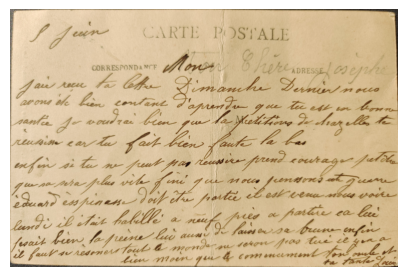

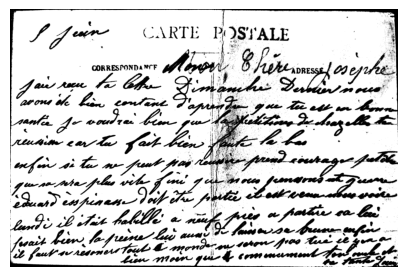

In [18]:
# Open a random verso cropped image
img_list = os.listdir('cropped')
i = np.random.randint(0, len(img_list)//2)
img_path = f'cropped/{i+1}_verso_cropped.jpg'
img = cv.imread(img_path)
plt.figure(figsize=(5, 5))
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Grey scale, threshold to binary
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
_, thresh = cv.threshold(gray, 175, 255, cv.THRESH_BINARY)
# Small blur to remove noise
blurred = cv.GaussianBlur(thresh, (5, 5), 0)
# Noise removal: erosion and dilation
kernel = np.ones((3, 3), np.uint8)
dilated = cv.dilate(blurred, kernel, iterations=1)
ocr_input = cv.erode(dilated, kernel, iterations=2)
plt.figure(figsize=(5, 5))
plt.imshow(ocr_input, cmap='gray')
plt.axis('off')
plt.show()


In [4]:
def ocr_preprocess(img_path):
    img = cv.imread(img_path)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    _, thresh = cv.threshold(gray, 175, 255, cv.THRESH_BINARY)
    blurred = cv.GaussianBlur(thresh, (5, 5), 0)
    kernel = np.ones((3, 3), np.uint8)
    dilated = cv.dilate(blurred, kernel, iterations=1)
    ocr_input = cv.erode(dilated, kernel, iterations=2)
    return ocr_input

#### Tesseract

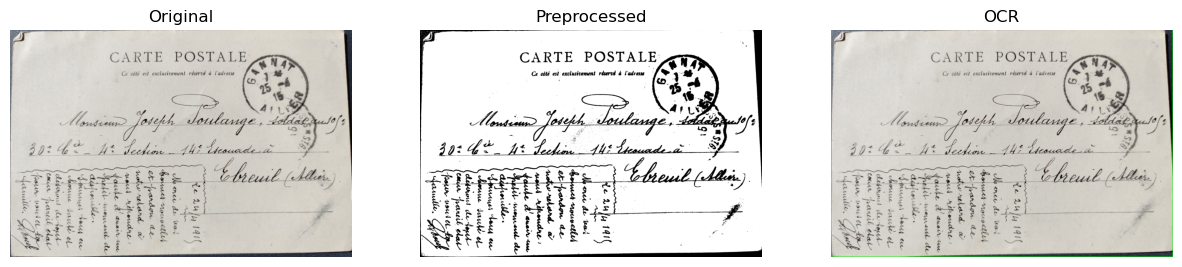

— CARTE mania (A ,
| Ce cbté est exclusivement riser . ~ % 6. J
‘ ‘ M41. -
THERE z a x
Shnih: i = —
See 3
SHEP RES



In [18]:
import pytesseract
from pytesseract import Output


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

img_list = os.listdir('cropped')
i = np.random.randint(0, len(img_list)//2)
img_path = f'cropped/{i+1}_verso_cropped.jpg'
img = cv.imread(img_path)

axes[0].imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
axes[0].set_title('Original')
axes[0].axis('off')

ocr_input = ocr_preprocess(img_path)

axes[1].imshow(ocr_input, cmap='gray')
axes[1].set_title('Preprocessed')
axes[1].axis('off')

tesseract_path = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
pytesseract.pytesseract.tesseract_cmd = tesseract_path

# OCR
ocr_output = ocr_input.copy()
custom_config = r'--oem 3 --psm 6'
text = pytesseract.image_to_string(ocr_input, config=custom_config)

# OCR with boxes
d = pytesseract.image_to_data(ocr_output, output_type=Output.DICT)
n_boxes = len(d['text'])
for i in range(n_boxes):
    if int(d['conf'][i]) > 0:
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        ocr_output = cv.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 10)

axes[2].imshow(cv.cvtColor(ocr_output, cv.COLOR_BGR2RGB))
axes[2].set_title('OCR')
axes[2].axis('off')
plt.show()

print(text)


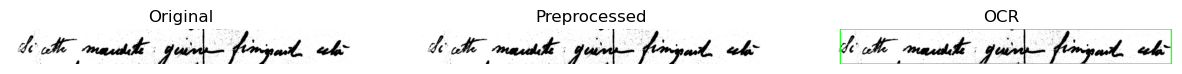

In [30]:
import pytesseract
from pytesseract import Output


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

img_list = os.listdir('test')
i = np.random.randint(0, len(img_list))
img_path = os.path.join('test', img_list[i])
img = cv.imread(img_path)


axes[0].imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
axes[0].set_title('Original')
axes[0].axis('off')

ocr_input = img

axes[1].imshow(ocr_input, cmap='gray')
axes[1].set_title('Preprocessed')
axes[1].axis('off')

tesseract_path = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
pytesseract.pytesseract.tesseract_cmd = tesseract_path

# OCR
ocr_output = ocr_input.copy()
custom_config = r'--oem 3 --psm 6'
text = pytesseract.image_to_string(ocr_input, config=custom_config)

# OCR with boxes
d = pytesseract.image_to_data(ocr_output, output_type=Output.DICT)
n_boxes = len(d['text'])
for i in range(n_boxes):
    if int(d['conf'][i]) > 0:
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        ocr_output = cv.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 10)

axes[2].imshow(cv.cvtColor(ocr_output, cv.COLOR_BGR2RGB))
axes[2].set_title('OCR')
axes[2].axis('off')
plt.show()

print(text)


#### Microsoft TROCR (Huggingface)

In [31]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
import requests

model_class = "large" # among ["base", "large"]

processor = TrOCRProcessor.from_pretrained(f'microsoft/trocr-{model_class}-handwritten')
model = VisionEncoderDecoderModel.from_pretrained(f'microsoft/trocr-{model_class}-handwritten')


c:\Users\chiro\anaconda3\envs\DL_env\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\chiro\anaconda3\envs\DL_env\lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\chiro\.cache\huggingface\hub\models--microsoft--trocr-large-handwritten. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run 

c:\Users\chiro\anaconda3\envs\DL_env\lib\site-packages\transformers\generation\utils.py:1141: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


0 1


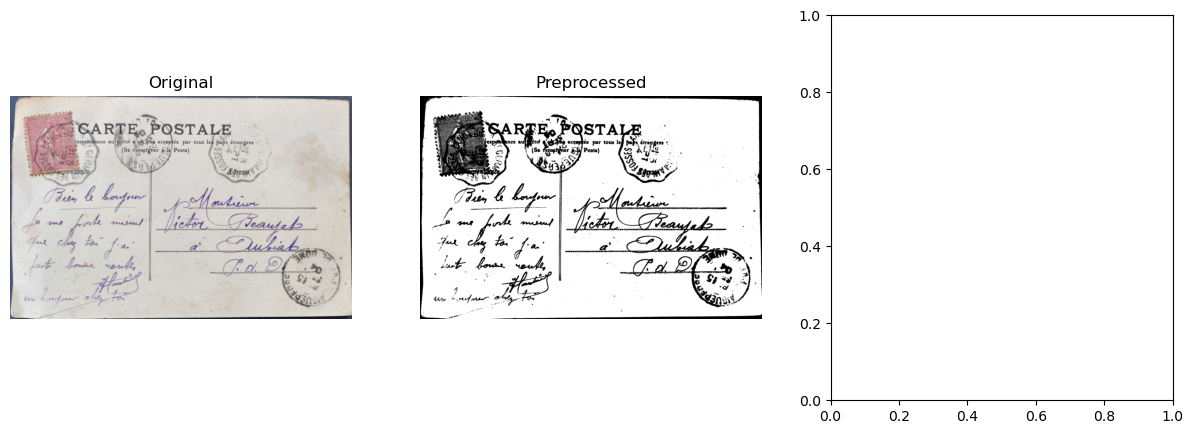

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

img_list = os.listdir('cropped')
i = np.random.randint(0, len(img_list)//2)
img_path = f'cropped/{i+1}_verso_cropped.jpg'
img = cv.imread(img_path)

axes[0].imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
axes[0].set_title('Original')
axes[0].axis('off')

ocr_input = ocr_preprocess(img_path)

axes[1].imshow(ocr_input, cmap='gray')
axes[1].set_title('Preprocessed')
axes[1].axis('off')

pixel_values = processor(images=img, return_tensors="pt").pixel_values
generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

print(generated_text)

Poulanges boutangers.


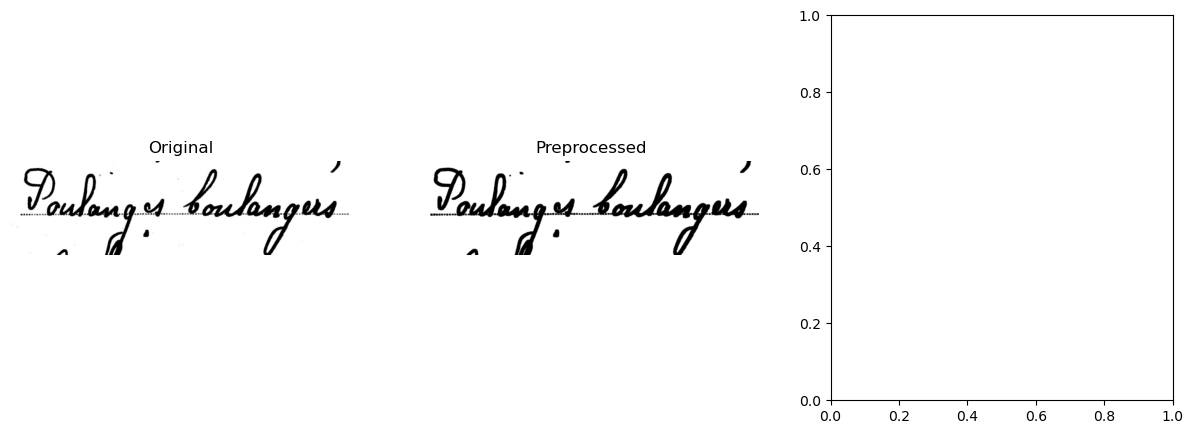

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

img_list = os.listdir('test')
i = np.random.randint(0, len(img_list))
img_path = os.path.join('test', img_list[i])
img = cv.imread(img_path)

axes[0].imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
axes[0].set_title('Original')
axes[0].axis('off')

ocr_input = ocr_preprocess(img_path)

axes[1].imshow(ocr_input, cmap='gray')
axes[1].set_title('Preprocessed')
axes[1].axis('off')

pixel_values = processor(images=img, return_tensors="pt").pixel_values
generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

print(generated_text)

#### Easyocr

(2378, 3656, 3)


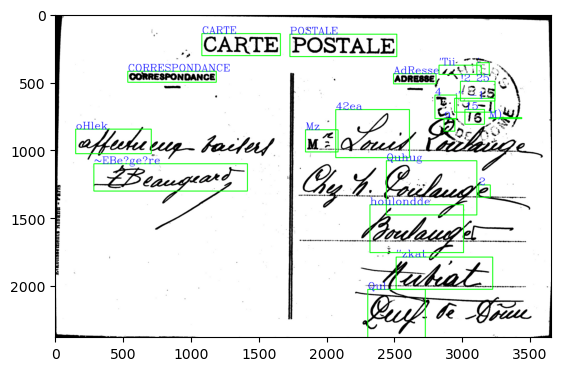

In [25]:
import cv2 as cv
import easyocr
import matplotlib.pyplot as plt
import numpy as np
import os

# read image
# img_list = os.listdir('cropped')
# i = np.random.randint(0, len(img_list)//2)
# img_path = f'cropped/{i+1}_verso_cropped.jpg'
# img = cv.imread(img_path)

img_list = os.listdir('ocr_input')
i = np.random.randint(0, len(img_list))
img_path = os.path.join('ocr_input', img_list[i])
img = cv.imread(img_path)
print(img.shape)
# img = cv.cvtColor(img, cv.COLOR_GRAY2RGB)


# instance text detector
reader = easyocr.Reader(['fr'], gpu=True)

# detect text on image
text_ = reader.readtext(img,
                        text_threshold=0.5,
                        low_text=0.4,
                        link_threshold=0.4,
                        canvas_size=2560
                        )

threshold = 0.1
# draw bbox and text
for t_, t in enumerate(text_):
    # print(t)
    bbox, text, score = t
    bbox = np.array(bbox).astype(int)
    if score > threshold:
        cv.rectangle(img, bbox[0], bbox[2], (0, 255, 0), 5)
        cv.putText(img, text, bbox[0], cv.FONT_HERSHEY_COMPLEX, 2.5, (255, 0, 0), 2)

plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.show()